# Imports

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os

import torch
from torchvision.datasets import ImageFolder
from torchvision.transforms import *
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from copy import deepcopy

from collections import Counter
from torch.utils.data import WeightedRandomSampler

import random
import shutil
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from PIL import Image

import re
import warnings
warnings.filterwarnings("ignore")

os.listdir('/kaggle/input/face-mask-detection')

['annotations', 'images']

In [2]:
base_dir = '/kaggle/input/face-mask-detection'
dest_dir = '/kaggle/working/face-mask-detection'

if os.path.isdir(dest_dir):
    shutil.rmtree(dest_dir)
shutil.copytree(base_dir, dest_dir)

base_dir = dest_dir

print(len(os.listdir(os.path.join(base_dir, 'annotations'))[:5]) == len(os.listdir(os.path.join(base_dir, 'images'))[:5]))

annotation_files = os.listdir(os.path.join(base_dir, 'annotations'))
img_files = os.listdir(os.path.join(base_dir, 'images'))

print(*annotation_files[:5], *img_files[:5])

True
maksssksksss47.xml maksssksksss370.xml maksssksksss117.xml maksssksksss11.xml maksssksksss412.xml maksssksksss3.png maksssksksss803.png maksssksksss431.png maksssksksss590.png maksssksksss543.png


# Parse xml

In [3]:
# check single xml format
from bs4 import BeautifulSoup

def read_single_xml(file_name='maksssksksss737.xml', no_obj=False):
    with open(os.path.join(base_dir, 'annotations', file_name), 'r') as f:
        xml_data = f.read()
    
    #print(xml_data)
    #print('---------------')
    
    soup = BeautifulSoup(xml_data, 'xml')
    
    folder = soup.folder
    filename = soup.filename
    
    objects = []
    for obj in soup.find_all('object'):
        obj_data = {
            'name': soup.find('name').text,
            #'pose': obj.pose.string,
            #'truncated': int(obj.truncated.string),
            #'occluded': int(obj.occluded.string),
            #'difficult': int(obj.difficult.string),
            'bndbox': {
                'xmin': int(obj.bndbox.xmin.string),
                'ymin': int(obj.bndbox.ymin.string),
                'xmax': int(obj.bndbox.xmax.string),
                'ymax': int(obj.bndbox.ymax.string)
            }
        }
        objects.append(obj_data)

    if no_obj:
        parsed_data = {
            'folder': folder.string,
            'filename': filename.string,
            'width': int(soup.width.string),
            'height': int(soup.height.string),
            'depth': int(soup.depth.string),
            'num_obj': len(objects)
        }
    else:
        parsed_data = {
            'folder': folder.string,
            'filename': filename.string,
            'width': int(soup.width.string),
            'height': int(soup.height.string),
            'depth': int(soup.depth.string),
            'objects': objects
        }

    return parsed_data
    
read_single_xml(no_obj=False)

{'folder': 'images',
 'filename': 'maksssksksss737.png',
 'width': 400,
 'height': 226,
 'depth': 3,
 'objects': [{'name': 'with_mask',
   'bndbox': {'xmin': 28, 'ymin': 55, 'xmax': 46, 'ymax': 71}},
  {'name': 'with_mask',
   'bndbox': {'xmin': 98, 'ymin': 62, 'xmax': 111, 'ymax': 78}},
  {'name': 'with_mask',
   'bndbox': {'xmin': 159, 'ymin': 50, 'xmax': 193, 'ymax': 90}},
  {'name': 'with_mask',
   'bndbox': {'xmin': 293, 'ymin': 59, 'xmax': 313, 'ymax': 80}},
  {'name': 'with_mask',
   'bndbox': {'xmin': 352, 'ymin': 51, 'xmax': 372, 'ymax': 72}},
  {'name': 'with_mask',
   'bndbox': {'xmin': 228, 'ymin': 53, 'xmax': 241, 'ymax': 73}}]}

# Simple data analysis

In [4]:
# check datas
list_of_files = [re.sub("\....","",x) for x in os.listdir(os.path.join(base_dir, 'annotations'))]
print(list_of_files[:5])

list_of_xml = [read_single_xml(x+".xml", no_obj=True) for x in list_of_files]

df = pd.DataFrame(list_of_xml)
df

['maksssksksss47', 'maksssksksss370', 'maksssksksss117', 'maksssksksss11', 'maksssksksss412']


folder             filename  width  height  depth  num_obj
0    images   maksssksksss47.png    400     268      3        1
1    images  maksssksksss370.png    301     400      3        1
2    images  maksssksksss117.png    301     400      3        1
3    images   maksssksksss11.png    400     267      3       16
4    images  maksssksksss412.png    400     400      3        2
..      ...                  ...    ...     ...    ...      ...
848  images   maksssksksss35.png    400     255      3        2
849  images  maksssksksss551.png    400     267      3        5
850  images  maksssksksss417.png    301     400      3        1
851  images  maksssksksss761.png    267     400      3        1
852  images  maksssksksss312.png    300     400      3        3

[853 rows x 6 columns]

In [5]:
df.describe()

width      height  depth     num_obj
count  853.000000  853.000000  853.0  853.000000
mean   370.589683  309.289566    3.0    4.773740
std     56.224049   74.474840    0.0    7.394114
min    193.000000  156.000000    3.0    1.000000
25%    301.000000  254.000000    3.0    1.000000
50%    400.000000  280.000000    3.0    2.000000
75%    400.000000  400.000000    3.0    6.000000
max    600.000000  600.000000    3.0  115.000000

In [6]:
df['depth'].unique()

array([3])

In [7]:
df[df['filename'].str.endswith('.png', na=False)]
# indicate all pngs

folder             filename  width  height  depth  num_obj
0    images   maksssksksss47.png    400     268      3        1
1    images  maksssksksss370.png    301     400      3        1
2    images  maksssksksss117.png    301     400      3        1
3    images   maksssksksss11.png    400     267      3       16
4    images  maksssksksss412.png    400     400      3        2
..      ...                  ...    ...     ...    ...      ...
848  images   maksssksksss35.png    400     255      3        2
849  images  maksssksksss551.png    400     267      3        5
850  images  maksssksksss417.png    301     400      3        1
851  images  maksssksksss761.png    267     400      3        1
852  images  maksssksksss312.png    300     400      3        3

[853 rows x 6 columns]

# Split the dataset

In [8]:
# split dataset, very useful, copy if you want

def split_dataset(base_dir, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, image_file_type='.png', annot_file_type='.xml'):
    """
    Splits a dataset into train, val, and test directories with corresponding images and annotations.

    Args:
        base_dir (str): Path to the base directory containing 'images' and 'annotations' folders.
        train_ratio (float): Ratio of data for training.
        val_ratio (float): Ratio of data for validation.
        test_ratio (float): Ratio of data for testing.

    Returns:
        None
    """
    # Validate ratios
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("train_ratio, val_ratio, and test_ratio must sum to 1.0")
    
    # Directories for images and annotations
    images_dir = os.path.join(base_dir, "images")
    annotations_dir = os.path.join(base_dir, "annotations")

    # Check if directories exist
    if not os.path.exists(images_dir) or not os.path.exists(annotations_dir):
        raise FileNotFoundError("Both 'images' and 'annotations' directories must exist in the base directory.")

    # Get all filenames (without extensions) from the images directory
    image_files = [f for f in os.listdir(images_dir) if os.path.isfile(os.path.join(images_dir, f))]
    base_filenames = [os.path.splitext(f)[0] for f in image_files]  # Remove extensions

    # Shuffle and split filenames
    random.shuffle(base_filenames)
    total_files = len(base_filenames)
    train_end = int(total_files * train_ratio)
    val_end = train_end + int(total_files * val_ratio)

    train_files = base_filenames[:train_end]
    val_files = base_filenames[train_end:val_end]
    test_files = base_filenames[val_end:]

    # Create output directories
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(base_dir, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(base_dir, split, "annotations"), exist_ok=True)

    # Function to copy files
    def copy_files(file_list, split):
        for base_name in file_list:
            # Copy images
            src_image = os.path.join(images_dir, base_name + image_file_type)  # Change extension if needed
            dst_image = os.path.join(base_dir, split, "images", base_name + image_file_type)
            if os.path.exists(src_image):
                shutil.copy(src_image, dst_image)

            # Copy annotations
            src_annotation = os.path.join(annotations_dir, base_name + annot_file_type)
            dst_annotation = os.path.join(base_dir, split, "annotations", base_name + annot_file_type)
            if os.path.exists(src_annotation):
                shutil.copy(src_annotation, dst_annotation)

    # Copy files to respective directories
    copy_files(train_files, "train")
    copy_files(val_files, "val")
    copy_files(test_files, "test")

    print("Dataset successfully split!")


split_dataset(base_dir)

Dataset successfully split!


In [9]:
print(os.listdir(base_dir))
os.listdir(os.path.join(base_dir, 'train'))

['images', 'annotations', 'train', 'test', 'val']


['images', 'annotations']

In [10]:
print(os.listdir(base_dir))
print(os.listdir(os.path.join(base_dir, 'train')))
print(os.listdir(os.path.join(base_dir, 'val')))
print(os.listdir(os.path.join(base_dir, 'test')))
tmp = os.listdir(os.path.join(base_dir, 'train'))[0]
print(len(os.listdir(os.path.join(base_dir, 'train', tmp))))
print(len(os.listdir(os.path.join(base_dir, 'test', tmp))))
print(len(os.listdir(os.path.join(base_dir, 'val', tmp))))

['images', 'annotations', 'train', 'test', 'val']
['images', 'annotations']
['images', 'annotations']
['images', 'annotations']
682
86
85


In [11]:
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

 # Create yaml

In [12]:
# without_mask, with_mask, mask_weared_incorrect
with open(os.path.join(base_dir, 'dataset.yaml'), 'w+') as f:
    f.write(f"""train: {os.path.join(train_dir)}  
val: {os.path.join(val_dir)}      
test: {os.path.join(test_dir)}    

nc: 3  

names:
  0: without_mask
  1: with_mask
  2: mask_weared_incorrect""")

"""with open(os.path.join(base_dir, 'dataset.yaml'), 'r') as f:
    s = f.read()
print(s)"""

"with open(os.path.join(base_dir, 'dataset.yaml'), 'r') as f:\n    s = f.read()\nprint(s)"

# Convert xml to yolo labels

In [13]:
"""
example.xml

{'folder': 'images',
 'filename': 'maksssksksss737.png',
 'width': 400,
 'height': 226,
 'depth': 3,
 'objects': [{'name': 'with_mask',
   'bndbox': {'xmin': 28, 'ymin': 55, 'xmax': 46, 'ymax': 71}},
  {'name': 'with_mask',
   'bndbox': {'xmin': 98, 'ymin': 62, 'xmax': 111, 'ymax': 78}},
  {'name': 'with_mask',
   'bndbox': {'xmin': 159, 'ymin': 50, 'xmax': 193, 'ymax': 90}},
  {'name': 'with_mask',
   'bndbox': {'xmin': 293, 'ymin': 59, 'xmax': 313, 'ymax': 80}},
  {'name': 'with_mask',
   'bndbox': {'xmin': 352, 'ymin': 51, 'xmax': 372, 'ymax': 72}},
  {'name': 'with_mask',
   'bndbox': {'xmin': 228, 'ymin': 53, 'xmax': 241, 'ymax': 73}}]}
"""

def convert_annotation(path):
    # input xml output yolo format label
    if not path.endswith('.xml'):
        return
    data = read_single_xml(path)
    types = {
        'without_mask': 0,
        'with_mask': 1,
        'mask_weared_incorrect': 2
    }
    file_name = re.sub('\....','',data['filename'])+'.txt'
    img_width = data['width']
    img_height = data['height']
    
    objs = data['objects']
    rows = []
    for obj in objs:
        class_id = types[obj['name']]
        
        x_min = obj['bndbox']['xmin']
        y_min = obj['bndbox']['ymin']
        x_max = obj['bndbox']['xmax']
        y_max = obj['bndbox']['ymax']
        
        x_center = ((x_min+x_max)/2)/img_width
        y_center = ((y_min+y_max)/2)/img_height
        width = abs(x_max-x_min)/img_width
        height = abs(y_max-y_min)/img_height
        
        s = f"{class_id} {x_center} {y_center} {width} {height}"
        rows.append(s)

    #print(rows)
    with open(path, 'w+') as f:
        for row in rows:
            f.write(row)
            f.write('\n')
    os.rename(path, re.sub('\....','.txt',path))


a=os.listdir(os.path.join(train_dir, 'annotations'))
b=os.listdir(os.path.join(test_dir, 'annotations'))
c=os.listdir(os.path.join(val_dir, 'annotations'))


for file in a:
    file = os.path.join(train_dir, 'annotations', file)
    convert_annotation(file)

for file in b:
    file = os.path.join(test_dir, 'annotations', file)
    convert_annotation(file)
    
for file in c:
    file = os.path.join(val_dir, 'annotations', file)
    convert_annotation(file)

In [14]:
os.listdir(os.path.join(base_dir, 'train', 'annotations'))[:5]

['maksssksksss38.txt',
 'maksssksksss291.txt',
 'maksssksksss239.txt',
 'maksssksksss11.txt',
 'maksssksksss496.txt']

In [15]:
with open(os.path.join(train_dir,'annotations',os.listdir(os.path.join(base_dir, 'train', 'annotations'))[0]), 'r') as f:
    s = f.read()
print(s)

1 0.53 0.42280701754385963 0.09 0.12982456140350876
1 0.67 0.4649122807017544 0.08 0.11578947368421053



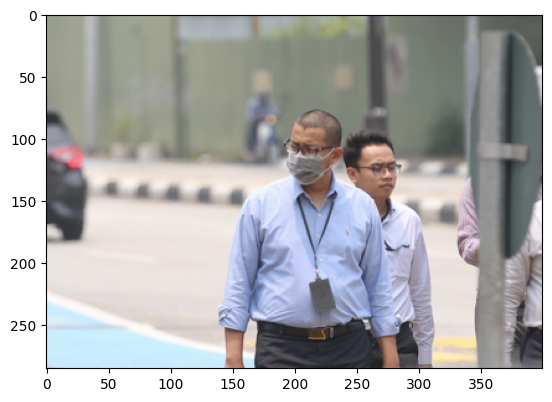

In [16]:
img = mpimg.imread(os.path.join(train_dir,'images',os.listdir(os.path.join(base_dir, 'train', 'annotations'))[0].replace('.txt', '.png')))
plt.imshow(img)
plt.show()

# Install yolo

In [17]:
try:
    from ultralytics import YOLO
except ModuleNotFoundError:
    !pip install ultralytics
    from ultralytics import YOLO

model = YOLO("yolo11n.pt")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 15.4 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.35M/5.35M [00:00<00:00, 66.8MB/s]


In [18]:
os.rename(os.path.join(train_dir, 'annotations'), os.path.join(train_dir, 'labels'))
os.rename(os.path.join(test_dir, 'annotations'), os.path.join(test_dir, 'labels'))
os.rename(os.path.join(val_dir, 'annotations'), os.path.join(val_dir, 'labels'))

# Training

In [19]:
import os
yaml_dir = os.path.join(base_dir, 'dataset.yaml')
results = model.train(
    data=yaml_dir,
    epochs=20, device=0, batch=-1
)

Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/working/face-mask-detection/dataset.yaml, epochs=20, time=None, patience=100, batch=-1, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

100%|██████████| 755k/755k [00:00<00:00, 17.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /kaggle/working/face-mask-detection/train/labels... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:01<00:00, 361.00it/s]

train: New cache created: /kaggle/working/face-mask-detection/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=640 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.74G total, 0.10G reserved, 0.06G allocated, 14.58G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2590425       6.443         0.480          70.6         449.5        (1, 3, 640, 640)                    list
     2590425       12.89         0.644         32.96           148        (2, 3, 640, 640)                    list
     2590425       25.77         0.969         37.36         116.6        (4, 3, 640, 640)                    list
     2590425       51.54         1.655         39.28         128.2        (8, 3, 640, 640)                    list
     2590425       103.1         2.98

train: Scanning /kaggle/working/face-mask-detection/train/labels.cache... 682 images, 0 backgrounds, 0 corrupt: 100%|██████████| 682/682 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/face-mask-detection/val/labels... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 371.66it/s]

val: New cache created: /kaggle/working/face-mask-detection/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.000734375), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      15.6G       2.41      4.175      1.987        188        640: 100%|██████████| 8/8 [00:09<00:00,  1.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:04<00:00,  4.19s/it]

                   all         85        333   0.000678     0.0317   0.000456   0.000117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      15.4G      1.646      3.619      1.295        239        640: 100%|██████████| 8/8 [00:06<00:00,  1.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.84s/it]

                   all         85        333    0.00211     0.0996      0.048     0.0297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      14.6G      1.499       2.72      1.146        777        640:  50%|█████     | 4/8 [00:03<00:03,  1.10it/s]

       3/20      14.7G      1.495      2.586      1.136        806        640:  75%|███████▌  | 6/8 [00:16<00:07,  3.52s/it]

       3/20      14.7G      1.493      2.479      1.125        272        640: 100%|██████████| 8/8 [00:25<00:00,  3.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         85        333    0.00572      0.644      0.154     0.0941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20        15G      1.407      1.761      1.071        302        640: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.09s/it]

                   all         85        333    0.00571       0.27       0.16     0.0953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      14.4G       1.33      1.528      1.049        166        640: 100%|██████████| 8/8 [00:06<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.24s/it]

                   all         85        333    0.00495      0.204      0.135      0.076



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      15.1G       1.24      1.413      1.017        173        640: 100%|██████████| 8/8 [00:07<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         85        333       0.98     0.0495      0.148      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      15.6G       1.23      1.325     0.9963        238        640: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         85        333      0.293      0.205      0.235       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      14.9G      1.223      1.321     0.9899        708        640:  38%|███▊      | 3/8 [00:02<00:04,  1.06it/s]

       8/20      15.4G      1.223      1.287      0.991        345        640: 100%|██████████| 8/8 [00:15<00:00,  1.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.10it/s]

                   all         85        333      0.987     0.0533      0.229      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      14.9G      1.204        1.2     0.9941        238        640: 100%|██████████| 8/8 [00:06<00:00,  1.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

                   all         85        333      0.704     0.0953       0.24      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      15.4G      1.215      1.233     0.9983        867        640:  38%|███▊      | 3/8 [00:02<00:04,  1.00it/s]

      10/20      15.4G      1.196      1.223     0.9911        208        640: 100%|██████████| 8/8 [00:14<00:00,  1.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]

                   all         85        333      0.676     0.0583      0.271      0.181


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      12.9G      1.227      1.491      1.033        414        640:  25%|██▌       | 2/8 [00:07<00:18,  3.15s/it]

      11/20      14.4G      1.212      1.374      1.001        123        640: 100%|██████████| 8/8 [00:24<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.29s/it]

                   all         85        333      0.693     0.0574      0.235      0.161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      14.9G       1.16      1.274     0.9849         83        640: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.24it/s]

                   all         85        333      0.329     0.0873      0.175      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      15.2G      1.143      1.277      0.976         60        640: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.28it/s]

                   all         85        333      0.303      0.111      0.183      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      15.4G      1.164      1.182      0.982        106        640: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

                   all         85        333      0.667     0.0529      0.163      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      14.9G       1.12      1.115     0.9826        423        640:  62%|██████▎   | 5/8 [00:04<00:02,  1.07it/s]

      15/20      14.5G      1.127      1.171     0.9706         92        640: 100%|██████████| 8/8 [00:15<00:00,  1.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]

                   all         85        333      0.328       0.23      0.278      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      15.3G      1.142      1.091      0.957        186        640: 100%|██████████| 8/8 [00:06<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.13it/s]

                   all         85        333      0.331      0.329      0.326      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20        15G        1.1       1.07     0.9581        202        640: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]

                   all         85        333      0.444      0.487       0.43      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      15.4G      1.092     0.9779     0.9535        110        640: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.27it/s]

                   all         85        333      0.524      0.483      0.523       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      14.9G       1.06     0.9271     0.9443         87        640: 100%|██████████| 8/8 [00:06<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

                   all         85        333      0.599      0.485      0.529      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      14.8G      1.068     0.9347     0.9472        182        640: 100%|██████████| 8/8 [00:06<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.57it/s]

                   all         85        333       0.61      0.483      0.529      0.372



20 epochs completed in 0.071 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.75 🚀 Python-3.10.12 torch-2.4.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]


                   all         85        333      0.611      0.483      0.528      0.372
          without_mask          7         37       0.29     0.0811      0.181       0.14
             with_mask         76        294      0.865      0.867      0.902      0.624
 mask_weared_incorrect          2          2      0.678        0.5      0.502      0.352
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train


# Results

In [20]:
result_dir = 'runs/detect/train'
os.listdir('runs/detect/train')

['train_batch1.jpg',
 'confusion_matrix.png',
 'train_batch0.jpg',
 'train_batch80.jpg',
 'R_curve.png',
 'train_batch2.jpg',
 'P_curve.png',
 'labels_correlogram.jpg',
 'PR_curve.png',
 'val_batch0_pred.jpg',
 'results.csv',
 'results.png',
 'weights',
 'F1_curve.png',
 'train_batch81.jpg',
 'labels.jpg',
 'train_batch82.jpg',
 'args.yaml',
 'events.out.tfevents.1739484611.3a243670f76f.21.0',
 'confusion_matrix_normalized.png',
 'val_batch0_labels.jpg']

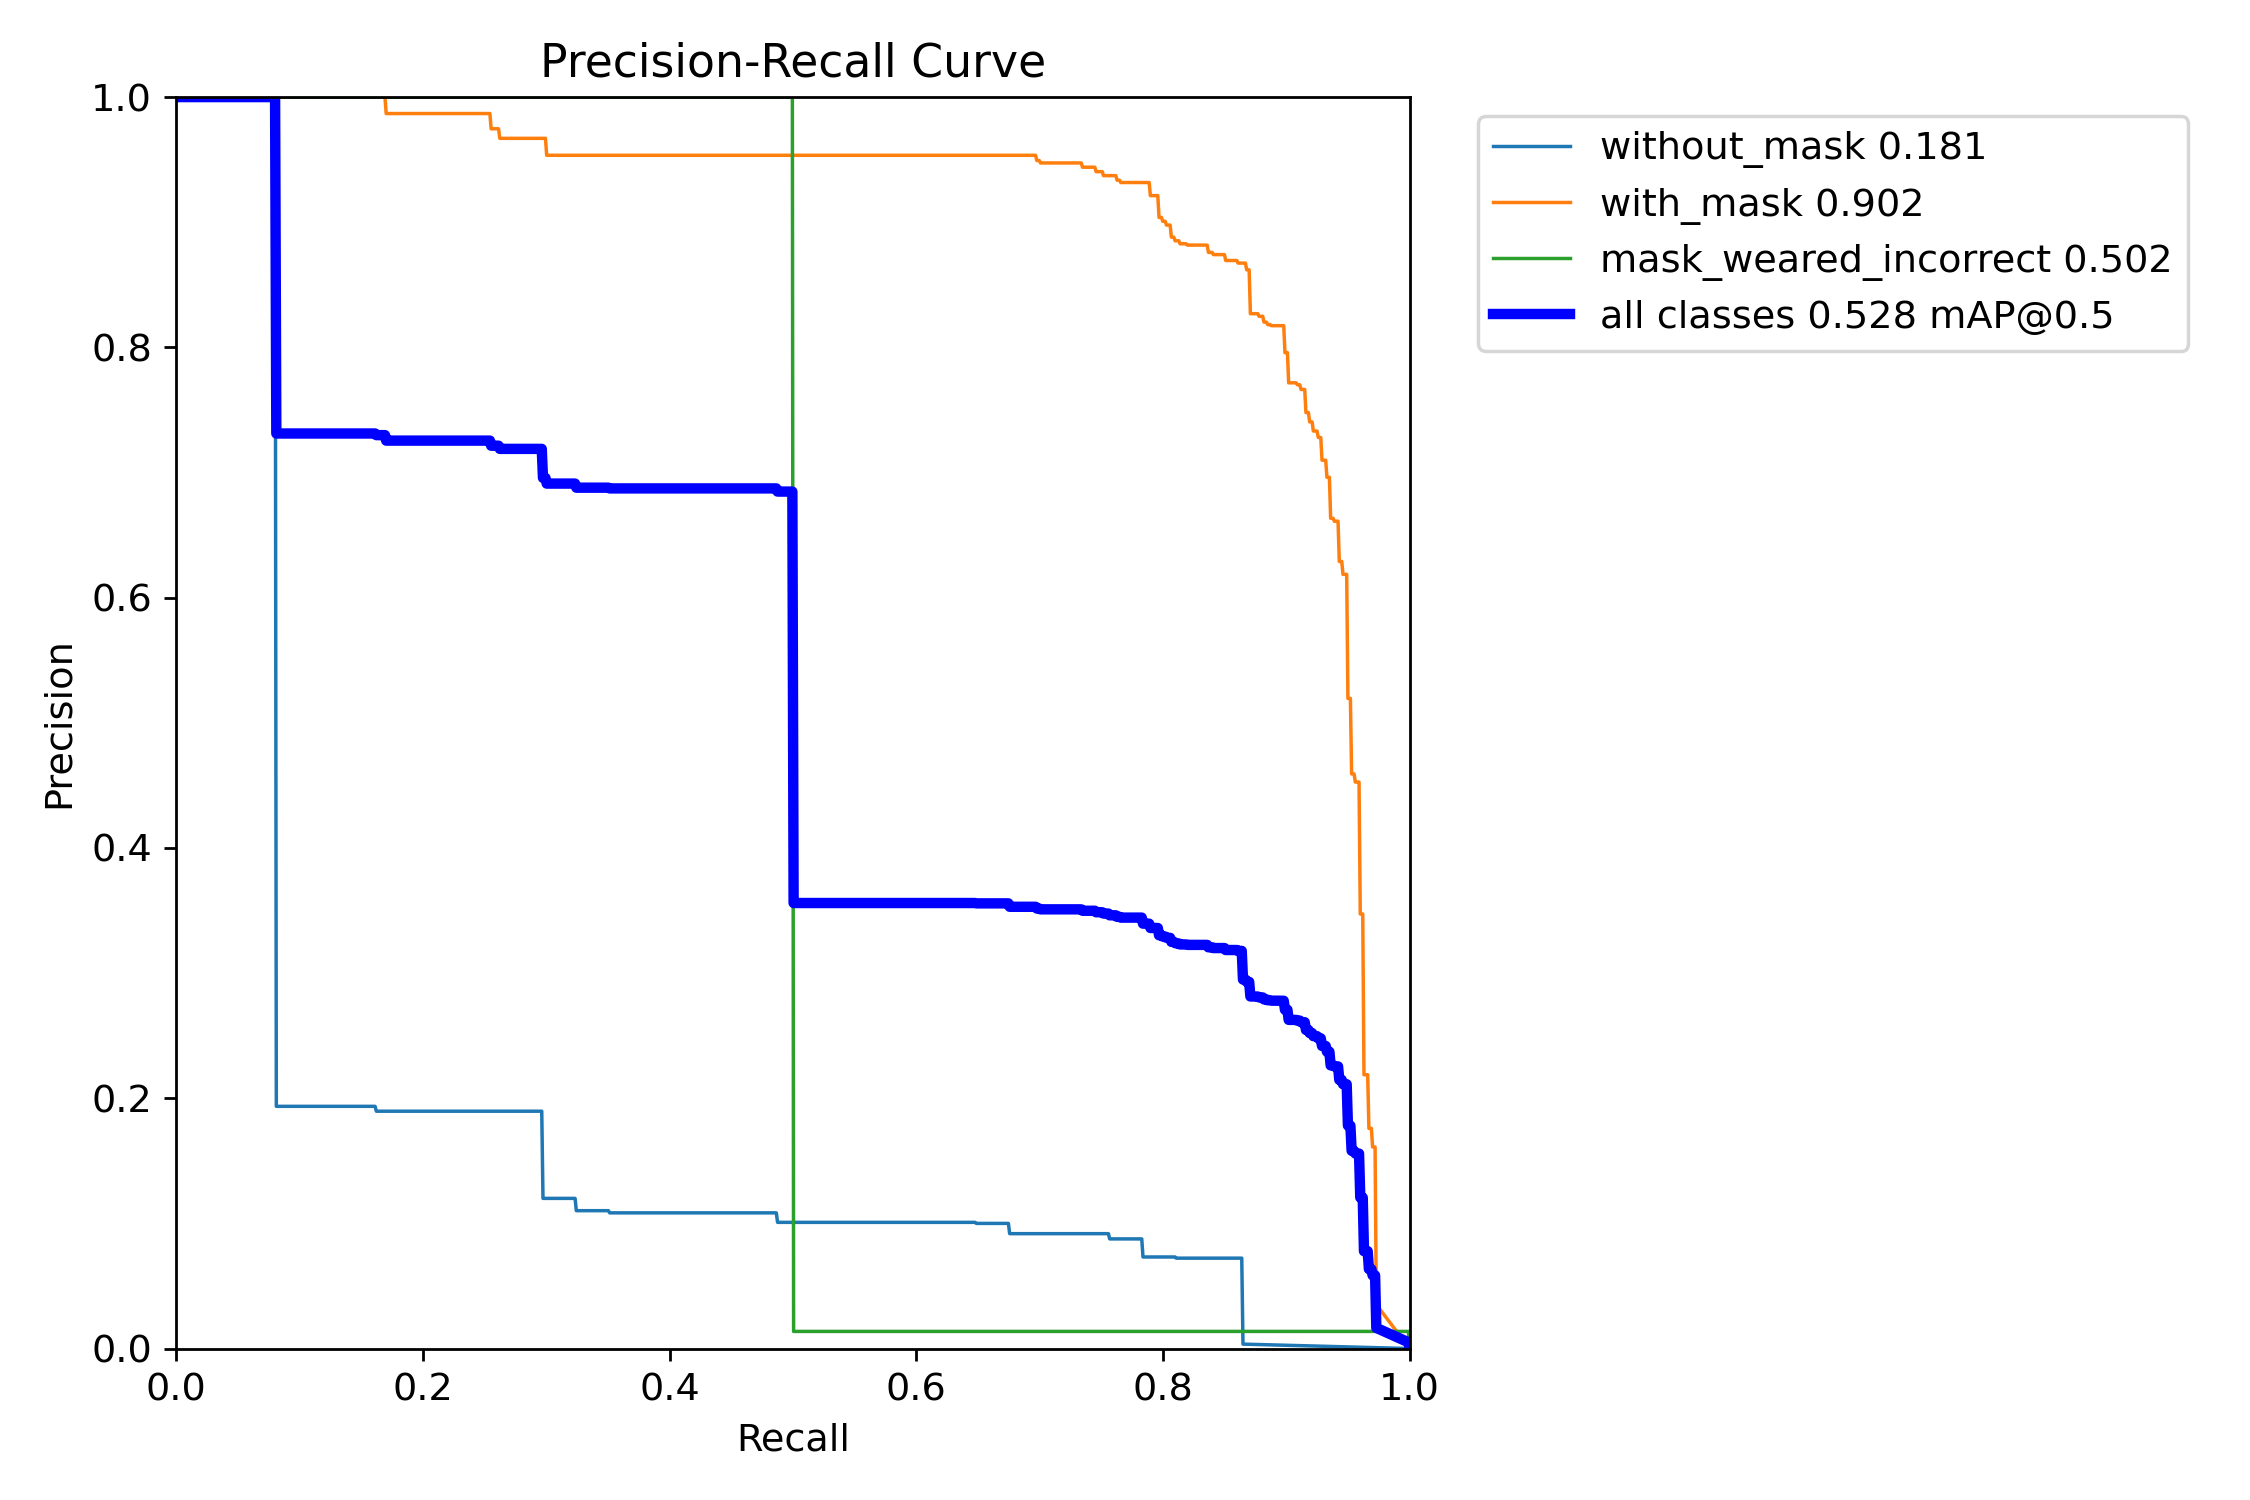

In [21]:
Image.open(os.path.join(result_dir, 'PR_curve.png'))
# The label of the dataset is not accurate enough, while some of the people without mask might get identified as masked.

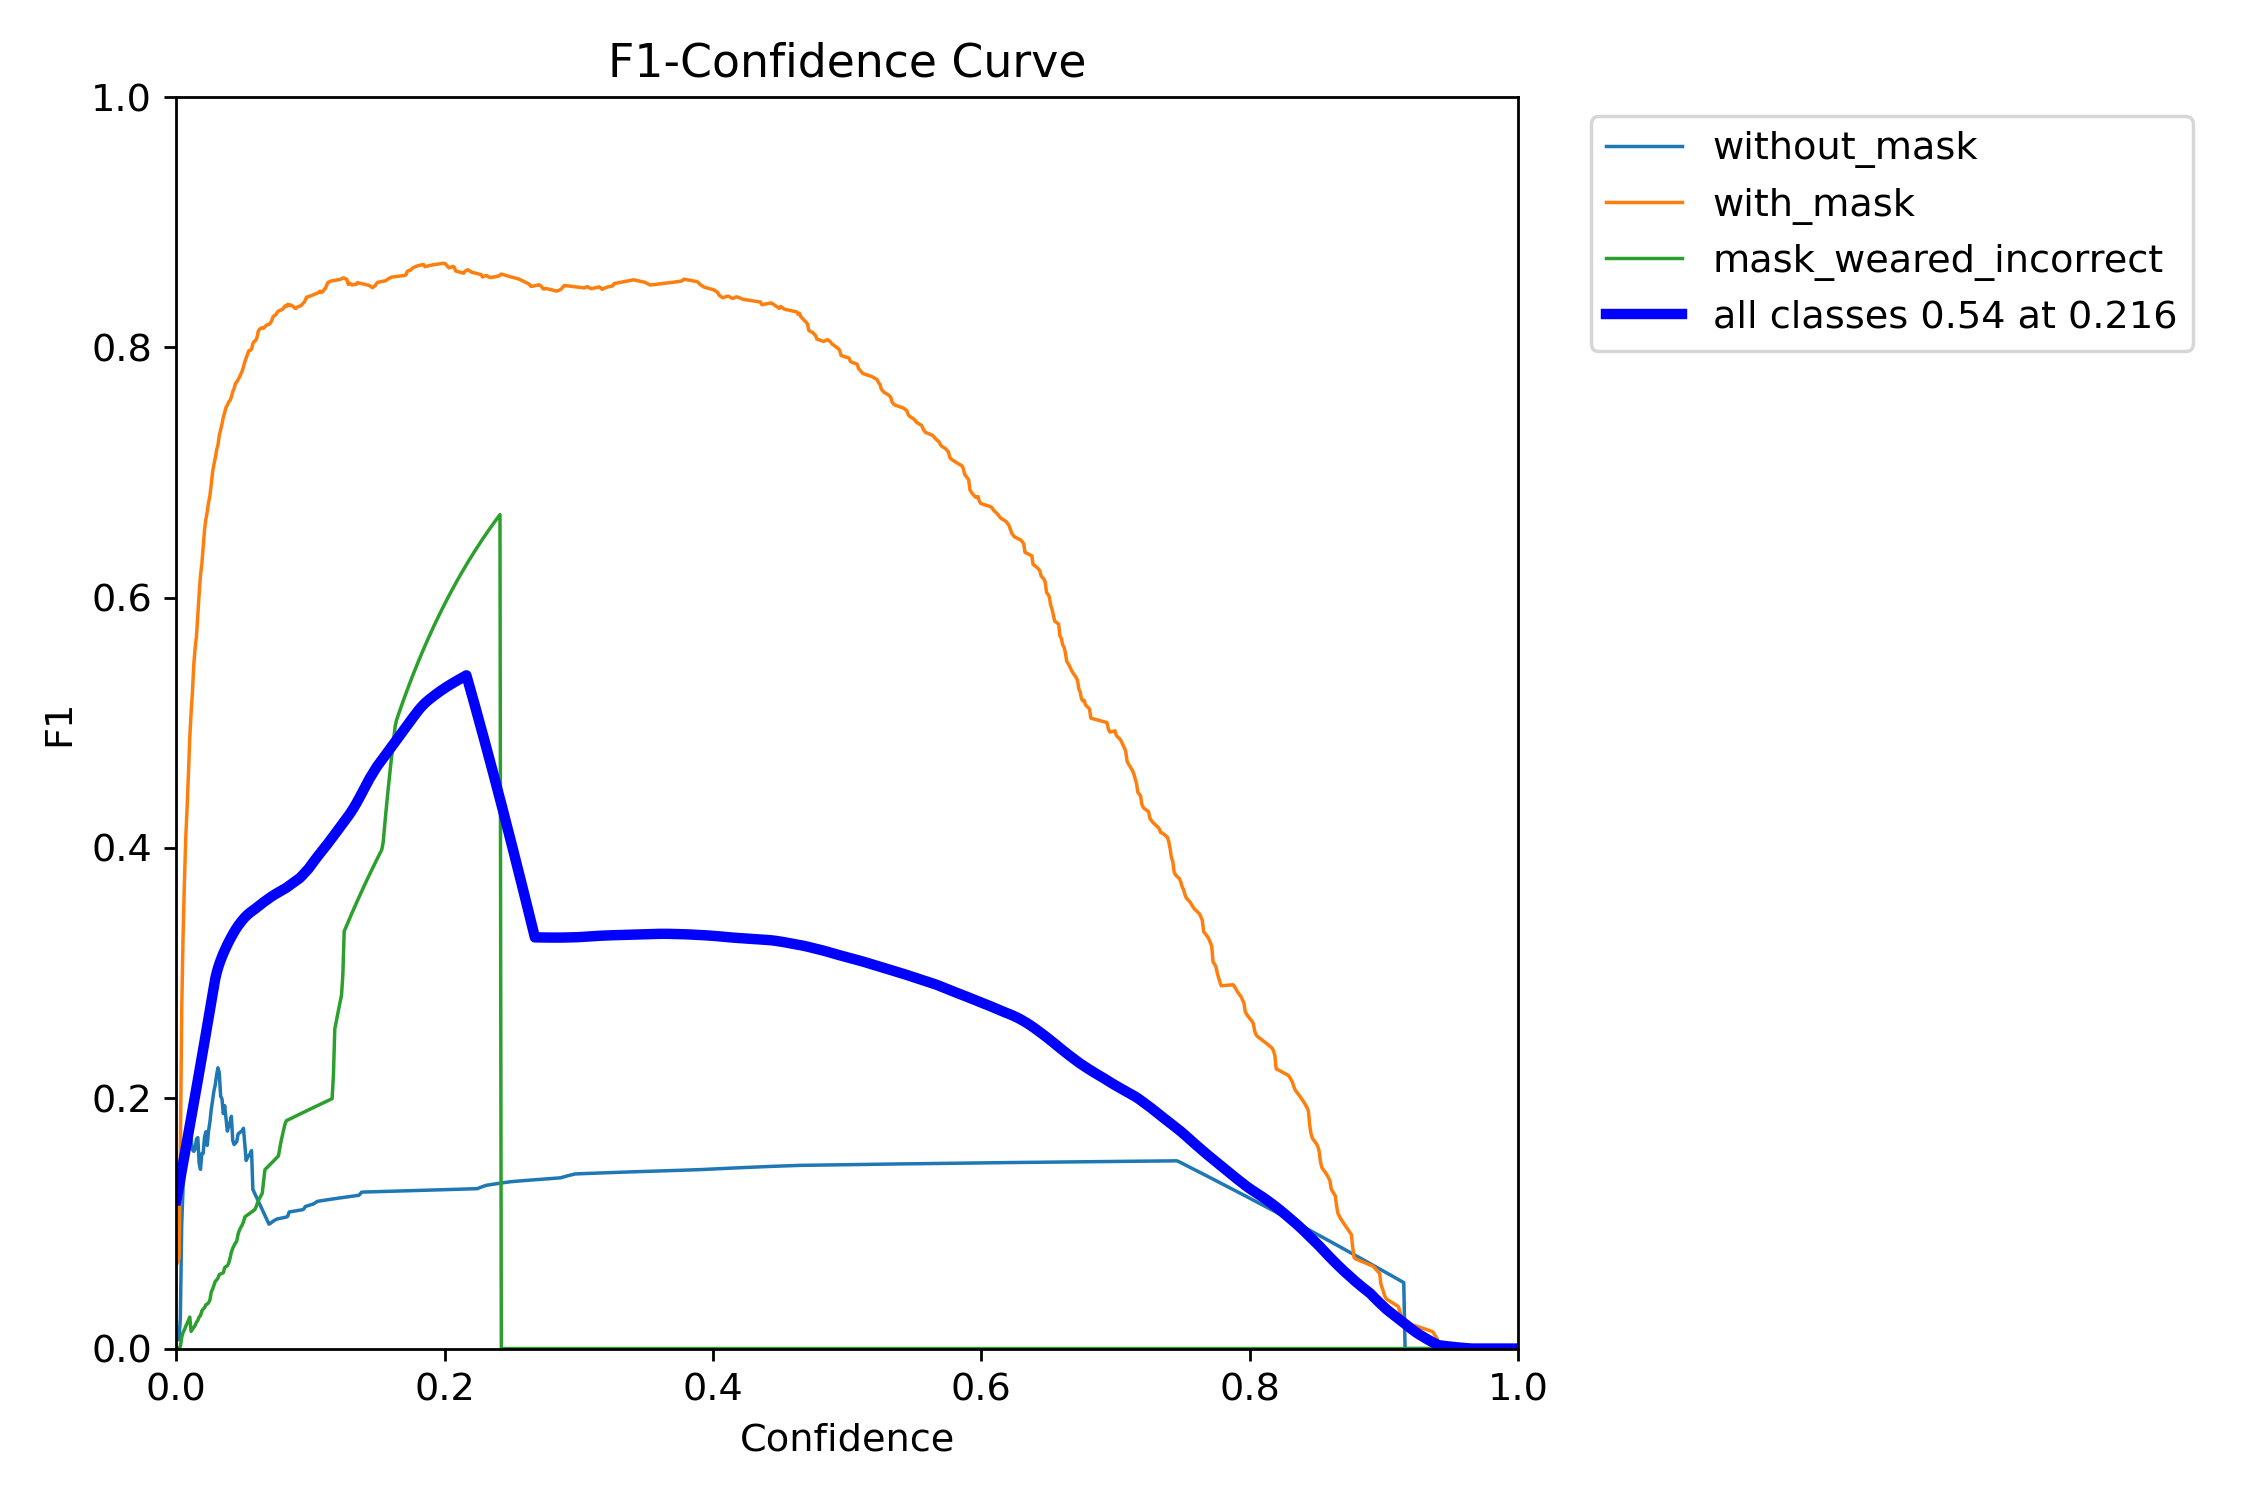

In [22]:
Image.open(os.path.join(result_dir, 'F1_curve.png'))

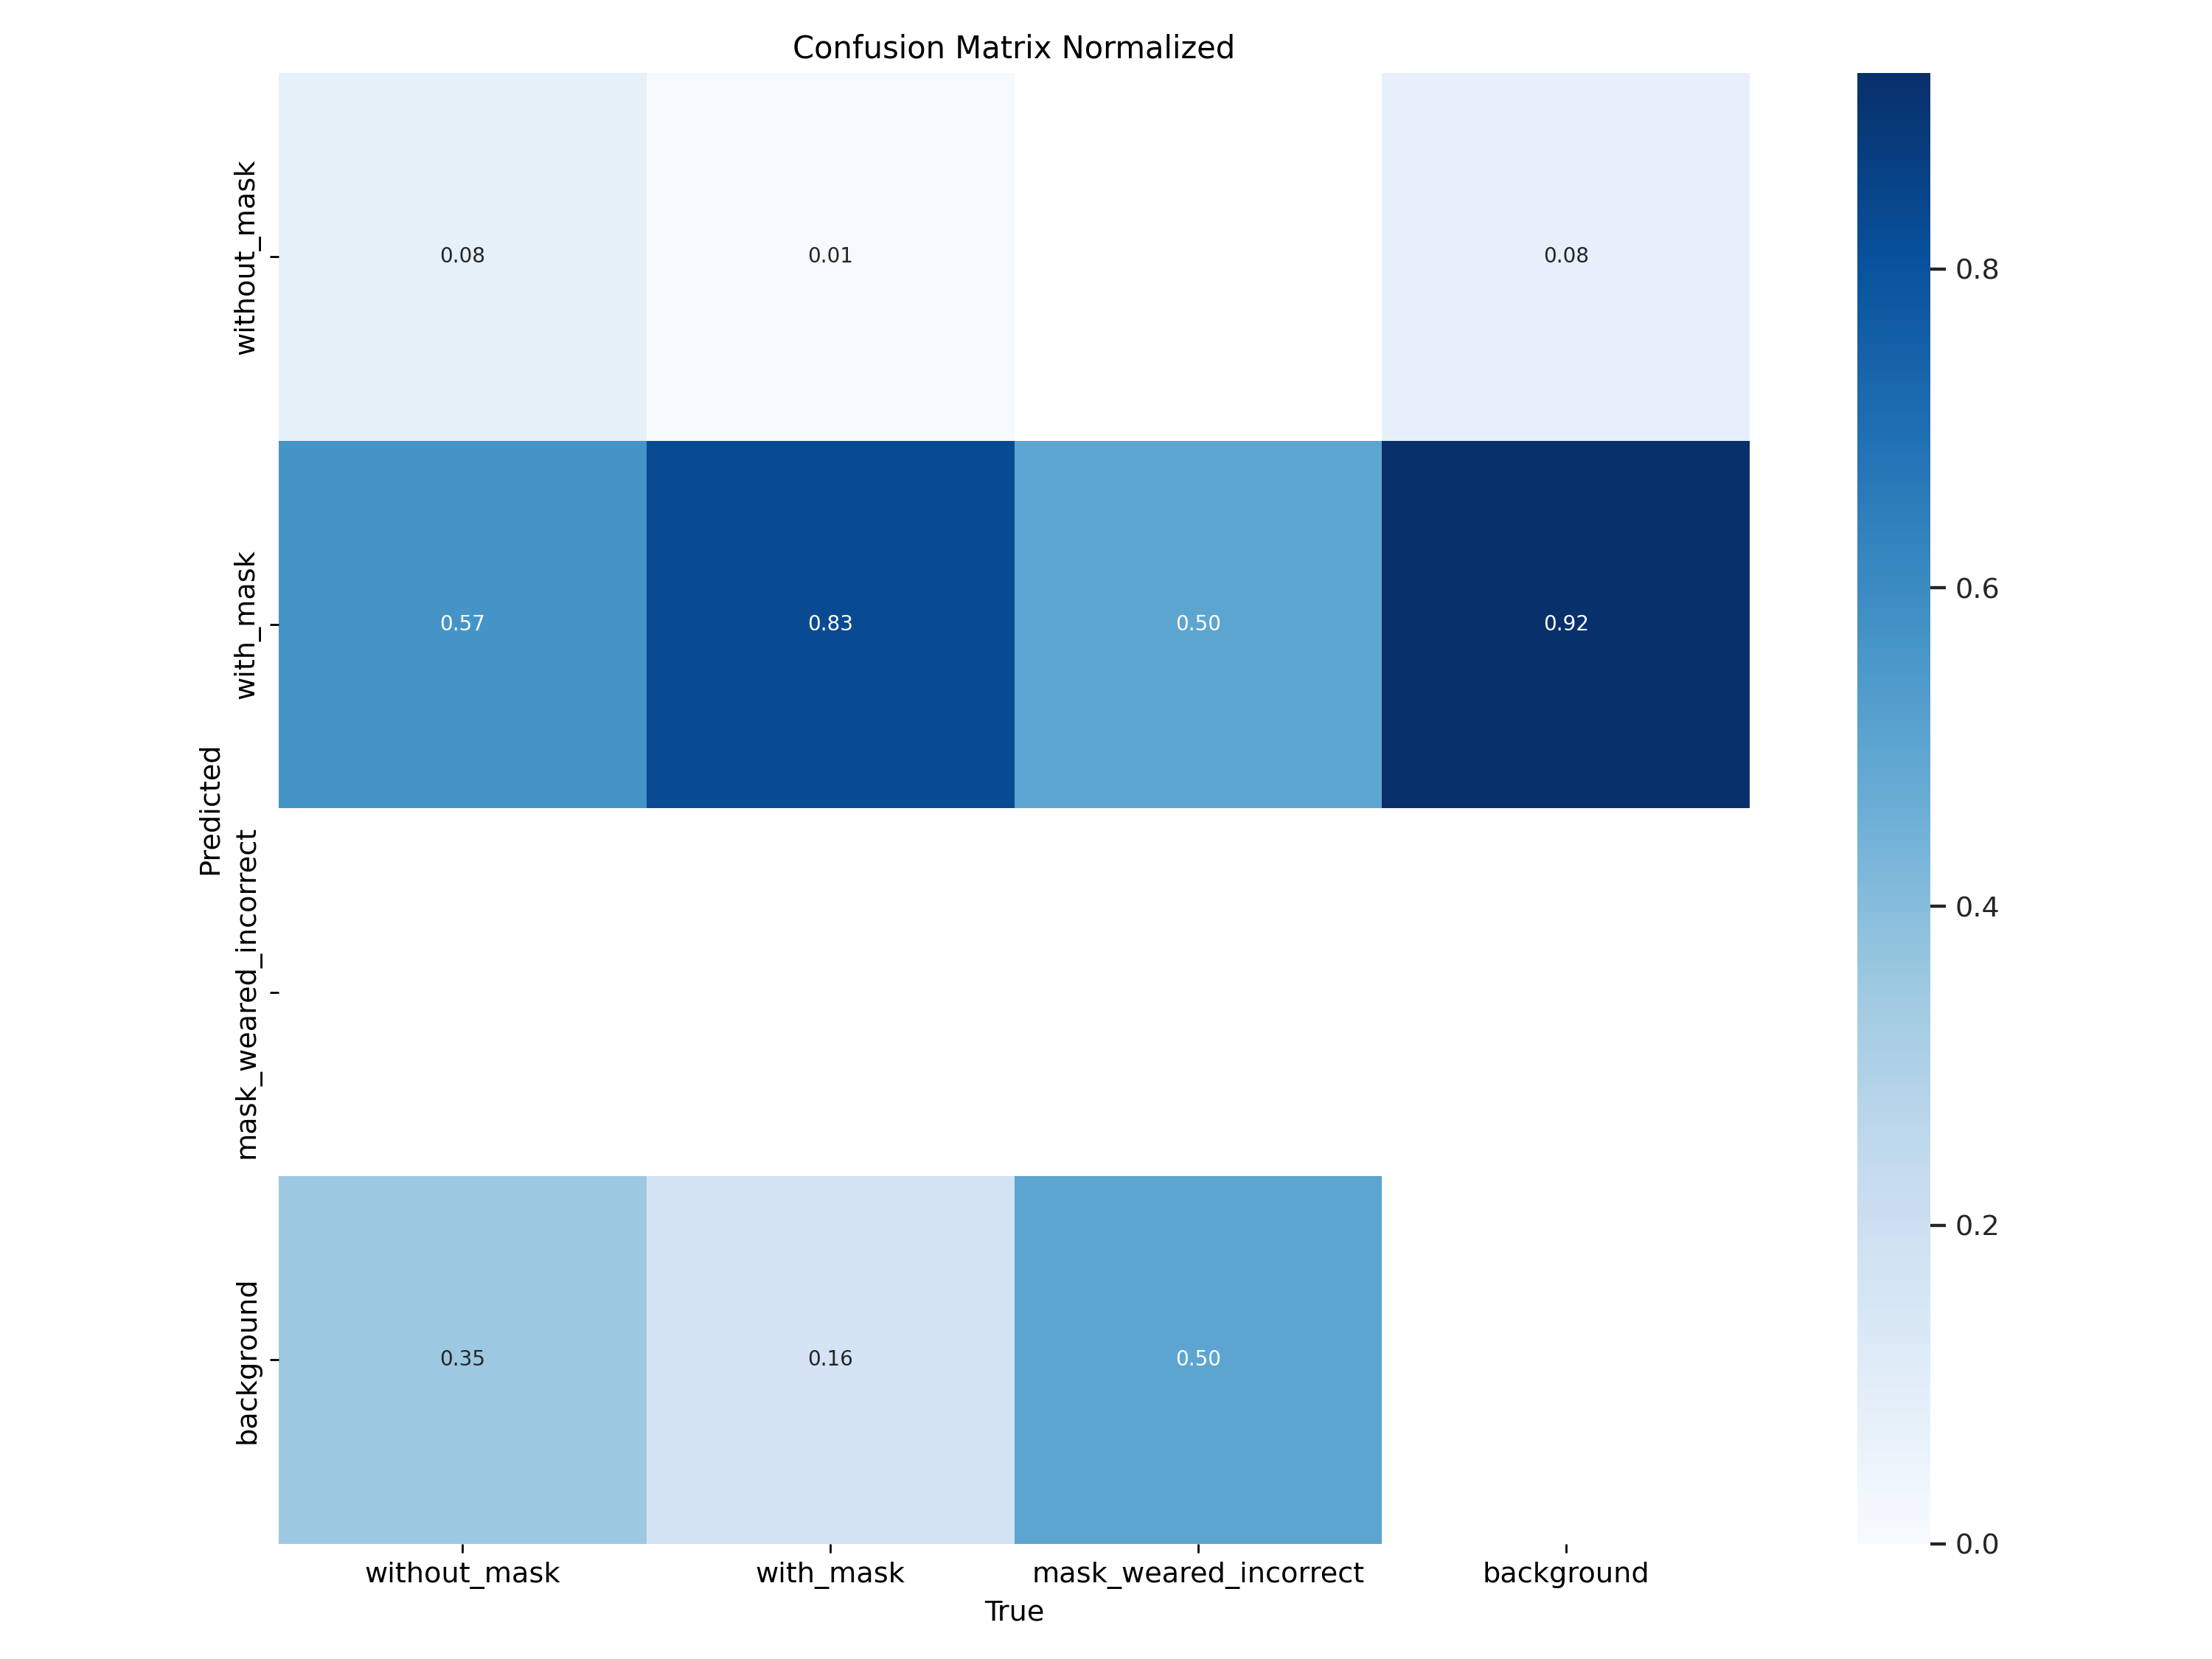

In [23]:
Image.open(os.path.join(result_dir, 'confusion_matrix_normalized.png'))

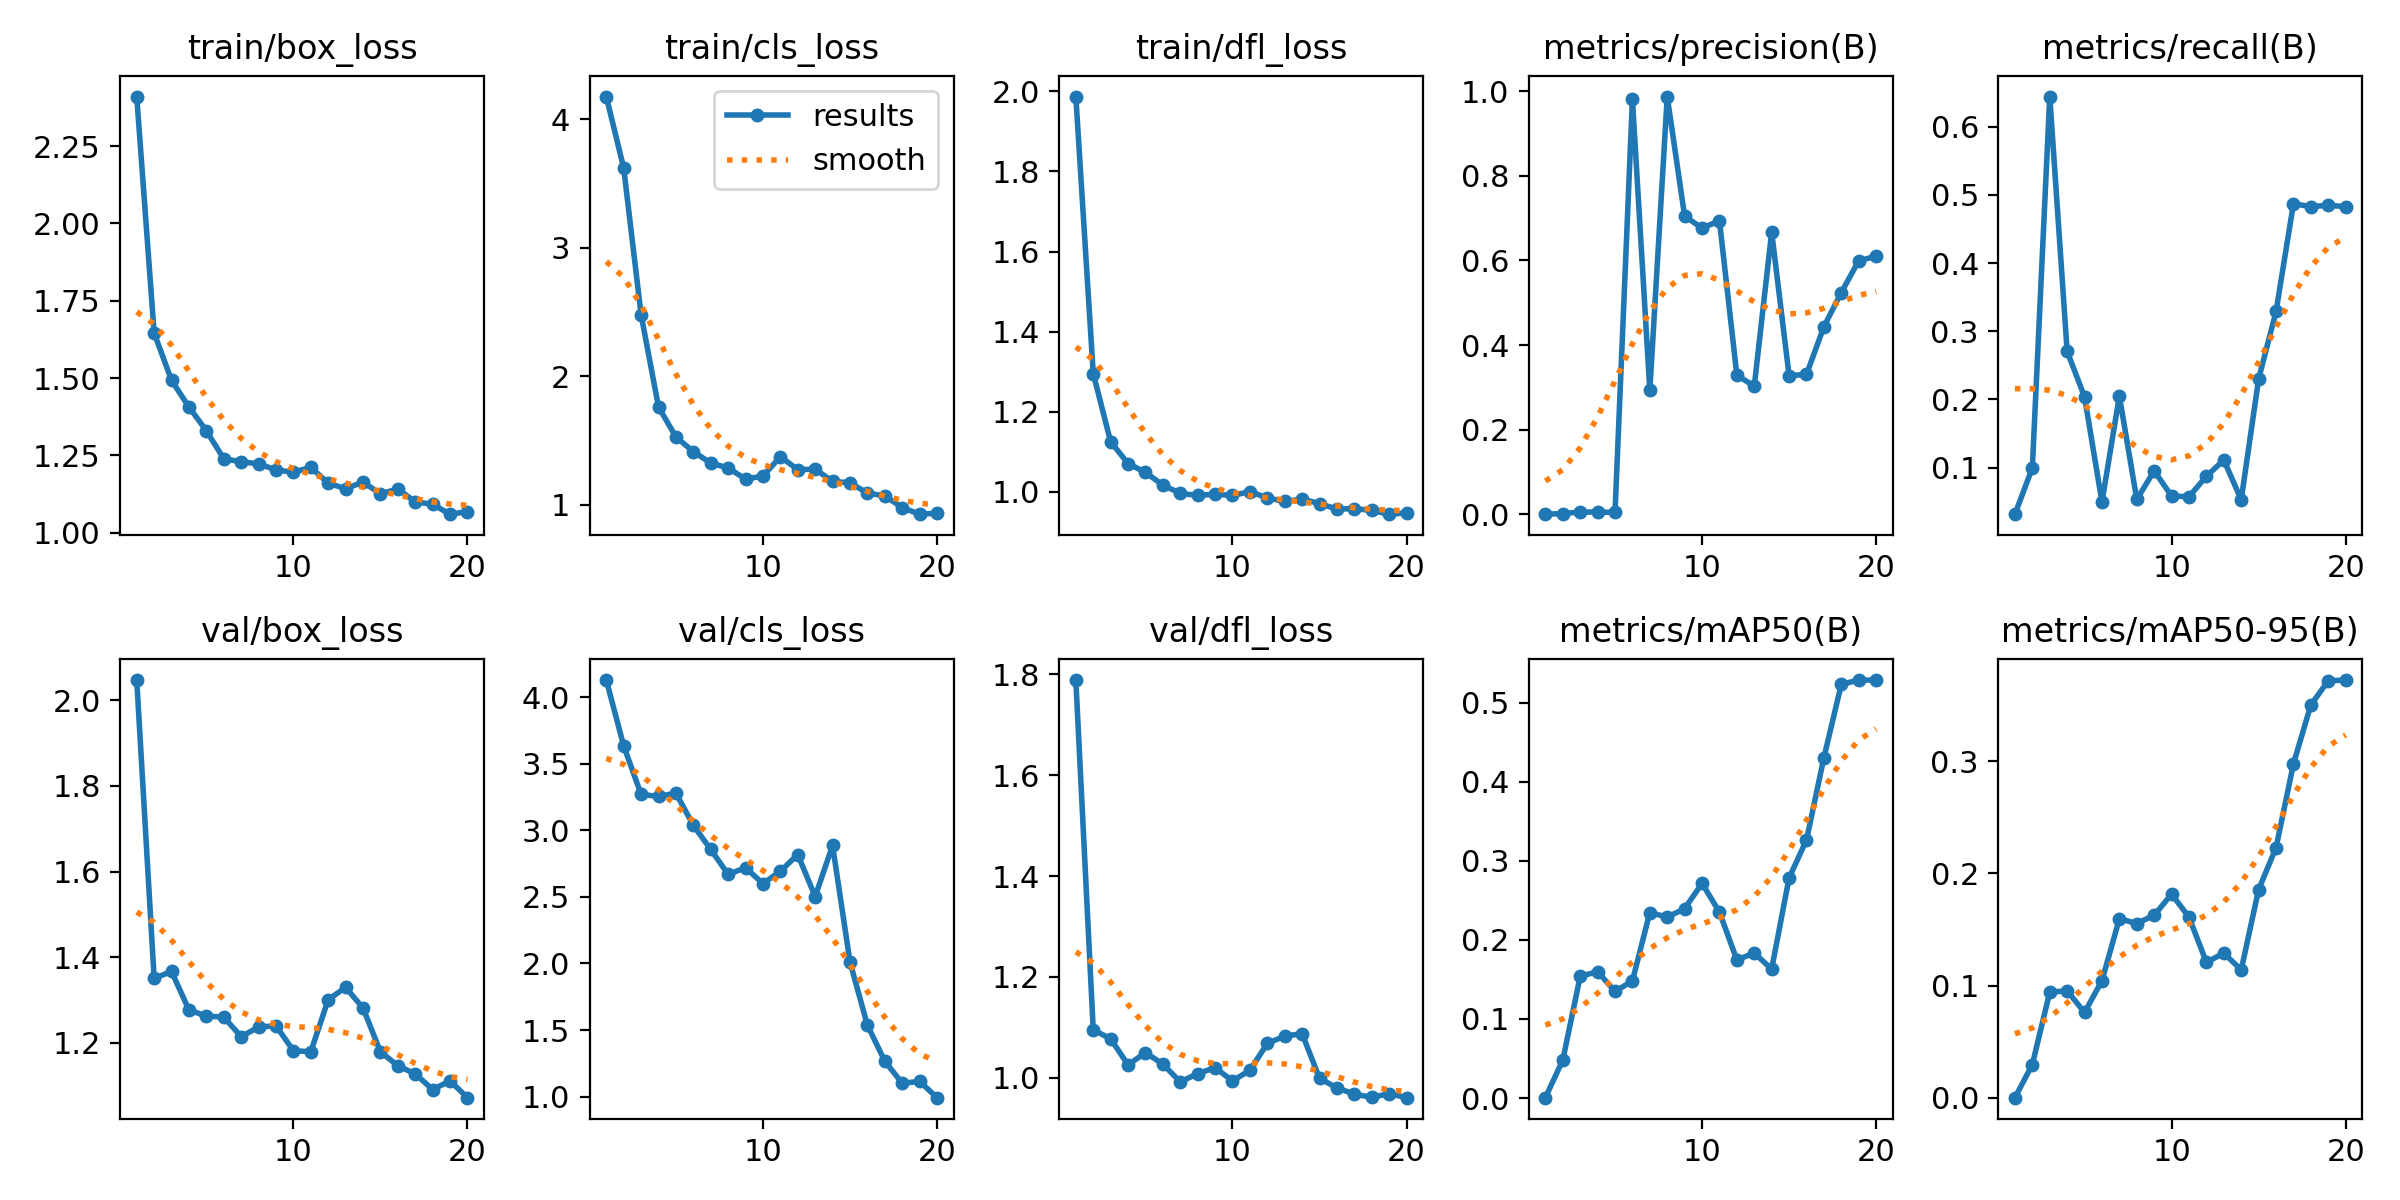

In [24]:
Image.open(os.path.join(result_dir, 'results.png'))

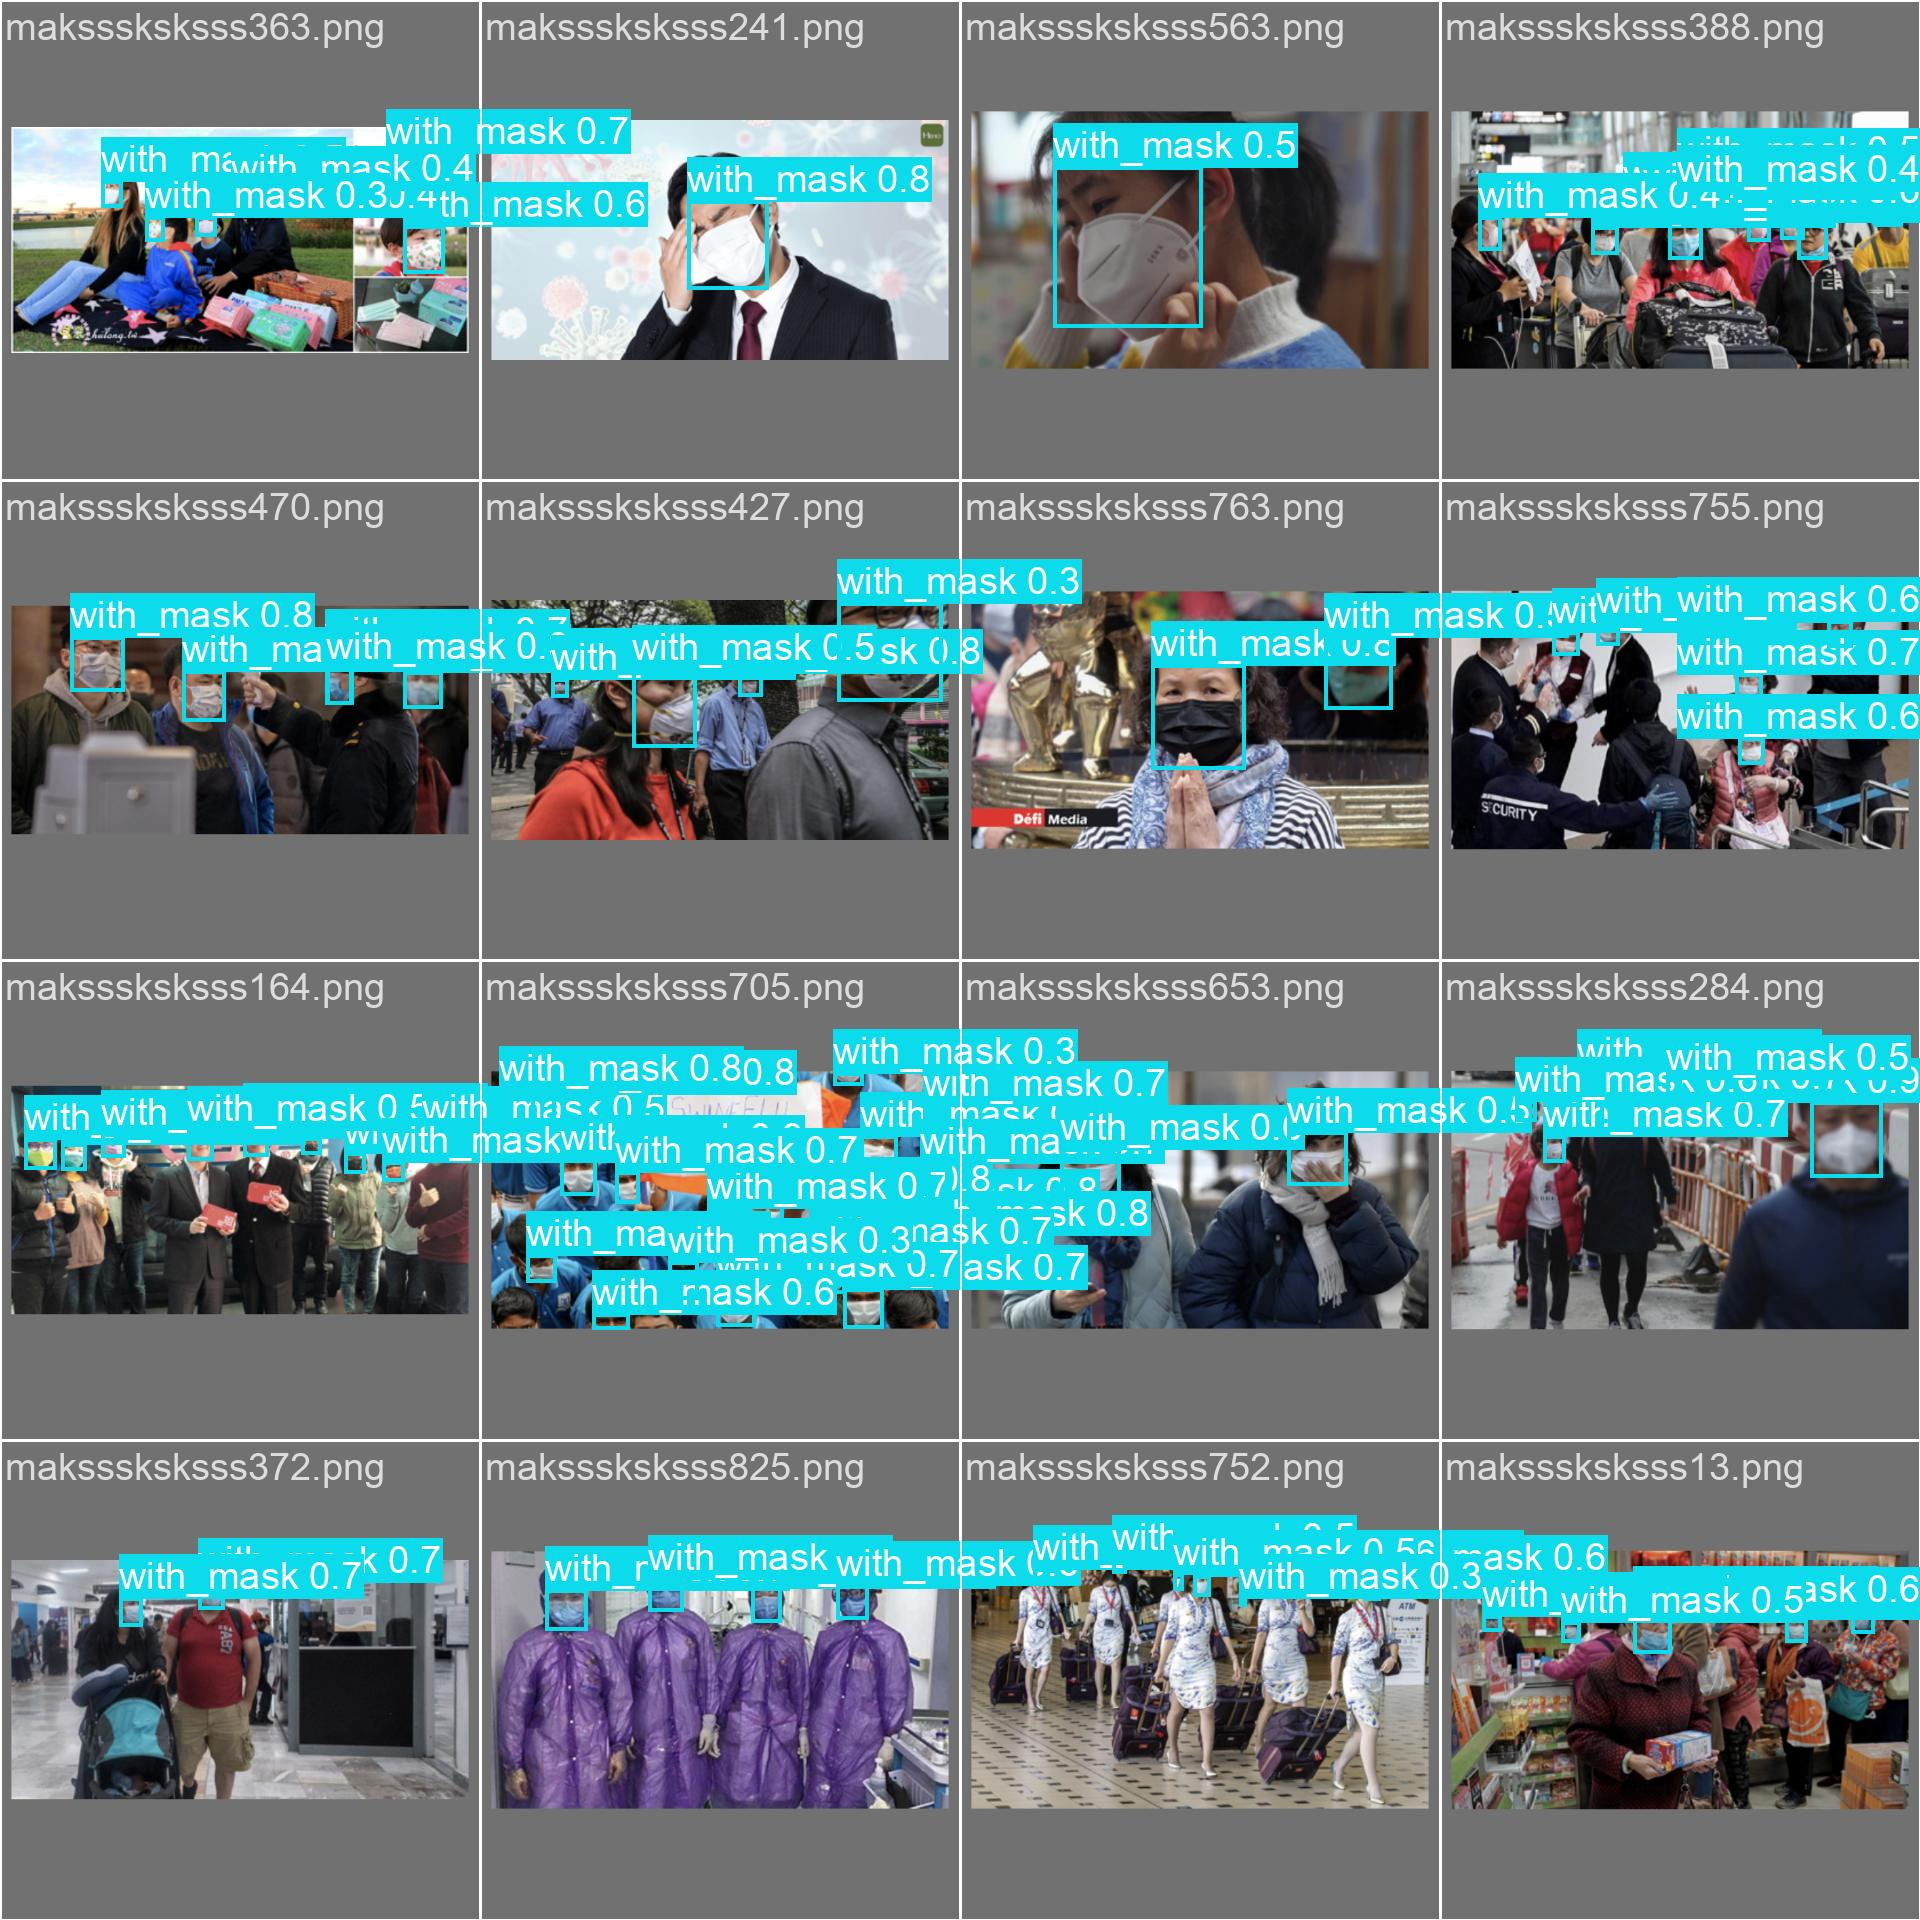

In [25]:
Image.open(os.path.join(result_dir, 'val_batch0_pred.jpg'))

# Discussion
* Modify the dataset to fit the yolo training process
* Use batch=-1 for auto batching during yolo training
* The dataset itself has many label errors for far distance faces, as seen in the confusion matrix and my observation in some of the labels.
* I believe the faces are cropped using facial landmarks, increasing the bounding box by 20%~30% would be better for the model to identify faces.

In [26]:
# 加载训练好的模型
model = YOLO("runs/detect/train/weights/best.pt")

# 使用模型对单张图片进行预测
results = model.predict(source="/kaggle/working/face-mask-detection/images/maksssksksss227.png", save=True)


image 1/1 /kaggle/working/face-mask-detection/images/maksssksksss227.png: 448x640 10 with_masks, 52.6ms
Speed: 2.1ms preprocess, 52.6ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/detect/predict


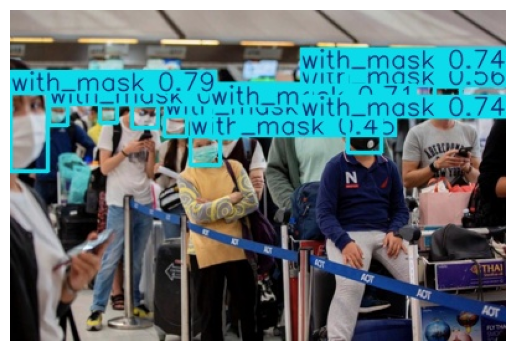

In [27]:
import matplotlib.pyplot as plt
import cv2

# 读取预测后的图像
img = cv2.imread("/kaggle/working/runs/detect/predict/maksssksksss227.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # OpenCV 默认是 BGR 需要转换为 RGB

# 显示图像
plt.imshow(img)
plt.axis("off")
plt.show()

In [28]:
import shutil

shutil.rmtree("/kaggle/working/runs/detect/predict", ignore_errors=True)
print("✅ 文件夹删除成功")

✅ 文件夹删除成功


In [29]:
cd /kaggle/working/

/kaggle/working
